In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [1]:
import pywt

from netCDF4 import Dataset
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, matthews_corrcoef, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

2024-08-24 10:32:07.897056: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-24 10:32:07.912800: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-24 10:32:07.918238: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-24 10:32:07.932917: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-24 10:32:08.760644: W tensorflow/compiler/tf2

## Input Data

In [2]:
ds = xr.open_dataset("../data/dataset_raw2.nc")
ds

<xarray.Dataset> Size: 484MB
Dimensions:            (samples: 246, time_steps: 15361, channels: 16)
Coordinates:
  * samples            (samples) int64 2kB 0 1 2 3 4 5 ... 241 242 243 244 245
Dimensions without coordinates: time_steps, channels
Data variables:
    signal             (samples, time_steps, channels) float64 484MB ...
    label              (samples) int64 2kB ...
    segments           (samples) int64 2kB ...
    patient_names      (samples) <U8 8kB ...
    recording_numbers  (samples) int64 2kB ...

In [3]:
X = ds["signal"].to_numpy()
y = ds["label"].to_numpy()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((164, 15361, 16), (82, 15361, 16), (164,), (82,))

In [5]:
np.unique(y, return_counts=True), np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([0, 1]), array([ 78, 168])),
 (array([0, 1]), array([ 52, 112])),
 (array([0, 1]), array([26, 56])))

## Create Model

In [6]:
@tf.py_function(Tout=[tf.float32, tf.float32])
def op_dwt(inputs, wavelet):
    input_signal = inputs.numpy()
    wavelet_str = wavelet.numpy().decode("ascii")

    cA, cD = pywt.dwt(input_signal, wavelet_str, axis=1)

    return cA, cD

class DWT(tf.keras.Layer):
    def __init__(self, wavelet="db4", name="DWT"):
        super().__init__(name=name)
        self.wavelet = wavelet
        self.n_channels = 0
        self.n_time_steps = 0

    # (n_batch, n_time_step, n_channels)
    def build(self, input_shape):
        temp_out, _ = pywt.dwt(np.ones((input_shape[1], input_shape[2])), self.wavelet, axis=0)

        self.n_channels = temp_out.shape[1]
        self.n_time_steps = temp_out.shape[0]

    # (n_batch, n_time_step, n_channels)
    def call(self, inputs):
        approx, details = op_dwt(inputs, self.wavelet)

        approx.set_shape((inputs.shape[0], self.n_time_steps, self.n_channels))
        details.set_shape((inputs.shape[0], self.n_time_steps, self.n_channels))

        # return [self.approx, self.details]
        return [approx, details]
    
    # (n_batch, n_time_step, n_channels)
    def compute_output_shape(self, input_shape):
        temp_out, _ = pywt.dwt(np.ones((input_shape[1], input_shape[2])), self.wavelet, axis=0)

        return [
            (input_shape[0], temp_out.shape[0], temp_out.shape[1]), 
            (input_shape[0], temp_out.shape[0], temp_out.shape[1])
        ]

In [ ]:
class ConvolutionalBlock(tf.keras.Model):
    def __init__(self, activation="relu", filters=32, kernel_size=3, strides=2, padding="same", pool_size=2):
        super(ConvolutionalBlock, self).__init__()
        # self.conv1 = tf.keras.layers.Conv1D(filters, kernel_size=kernel_size, strides=strides, padding=padding)
        # self.batch_norm = tf.keras.layers.BatchNormalization()
        # self.activation = tf.keras.layers.Activation(activation)
        # self.pooling = tf.keras.layers.MaxPool1D(pool_size=pool_size)
        # self.dropout = tf.keras.layers.SpatialDropout1D(0.1)

        self.conv1a = tf.keras.layers.Conv1D(16, kernel_size=1, padding="same")
        self.bn1a = tf.keras.layers.BatchNormalization()

        self.conv2a = tf.keras.layers.Conv1D(filters, kernel_size=8, padding="same")
        self.bn2a = tf.keras.layers.BatchNormalization()

        self.conv3a = tf.keras.layers.Conv1D(16, kernel_size=1, padding="same")
        self.bn3a = tf.keras.layers.BatchNormalization()

    def call(self, inputs, training=False):
        # x = self.conv1(inputs, training=training)
        # x = self.batch_norm(x, training=training)
        # x = self.activation(x, training=training)
        # x = self.dropout(x, training=training)
        # x = self.pooling(x, training=training)

        x = self.conv1a(inputs, training=training)
        x = self.bn1a(x, training=training)
        x = tf.nn.relu(x)

        x = self.conv2a(x, training=training)
        x = self.bn2a(x, training=training)
        x = tf.nn.relu(x)

        x = self.conv3a(x, training=training)
        x = self.bn3a(x, training=training)
        x = tf.nn.relu(x)

        x += inputs
        return x

In [84]:
# create model
inputs = tf.keras.layers.Input(shape=(15361, 16,))

# hi-freq
x1 = tf.keras.layers.Conv1D(64, kernel_size=64, strides=64, padding="same")(inputs)
x1 = tf.keras.layers.MaxPool1D(pool_size=8, strides=8)(x1)
x1 = tf.keras.layers.Dropout(0.5)(x1)

x1 = tf.keras.layers.Conv1D(128, kernel_size=8, padding="same")(x1)
x1 = tf.keras.layers.BatchNormalization()(x1)
x1 = tf.keras.layers.ReLU()(x1)

x1 = tf.keras.layers.Conv1D(128, kernel_size=8, padding="same")(x1)
x1 = tf.keras.layers.BatchNormalization()(x1)
x1 = tf.keras.layers.ReLU()(x1)

x1 = tf.keras.layers.Conv1D(128, kernel_size=8, padding="same")(x1)
x1 = tf.keras.layers.BatchNormalization()(x1)
x1 = tf.keras.layers.ReLU()(x1)

x1 = tf.keras.layers.MaxPool1D(pool_size=4, strides=4)(x1)

# low-freq
x2 = tf.keras.layers.Conv1D(64, kernel_size=256, strides=64, padding="same")(inputs)
x2 = tf.keras.layers.MaxPool1D(pool_size=4, strides=4)(x2)
x2 = tf.keras.layers.Dropout(0.5)(x2)

x2 = tf.keras.layers.Conv1D(128, kernel_size=6, padding="same")(x2)
x2 = tf.keras.layers.BatchNormalization()(x2)
x2 = tf.keras.layers.ReLU()(x2)

x2 = tf.keras.layers.Conv1D(128, kernel_size=6, padding="same")(x2)
x2 = tf.keras.layers.BatchNormalization()(x2)
x2 = tf.keras.layers.ReLU()(x2)

x2 = tf.keras.layers.Conv1D(128, kernel_size=6, padding="same")(x2)
x2 = tf.keras.layers.BatchNormalization()(x2)
x2 = tf.keras.layers.ReLU()(x2)

x2 = tf.keras.layers.MaxPool1D(pool_size=2, strides=2)(x2)

conc = tf.keras.layers.Concatenate(axis=1)([x1, x2])

do1 = tf.keras.layers.Dropout(0.5)(conc)
b1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True))(do1)
b1 = tf.keras.layers.Dropout(0.5)(b1)
b1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512))(b1)
b1 = tf.keras.layers.Dropout(0.5)(b1)

d1 = tf.keras.layers.Flatten()(do1)
d1 = tf.keras.layers.Dense(1024)(d1)
d1 = tf.keras.layers.BatchNormalization()(d1)
d1 = tf.keras.layers.ReLU()(d1)

out = tf.keras.layers.Add()([b1, d1])
out = tf.keras.layers.Dropout(0.5)(out)

outputs = tf.keras.layers.Dense(1, activation="sigmoid")(out)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [85]:
model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27      │ (None, 15361, 16) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_148 (Conv1D) │ (None, 241, 64)   │     65,600 │ input_layer_27[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_152 (Conv1D) │ (None, 241, 64)   │    262,208 │ input_layer_27[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_96    │ (None, 30, 64)    │          0 │ conv1d_148[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_98    │ (None, 60, 64)    │          0 │ conv1d_152[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_109         │ (None, 30, 64)    │          0 │ max_pooling1d_96… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_110         │ (None, 60, 64)    │          0 │ max_pooling1d_98… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_149 (Conv1D) │ (None, 30, 128)   │     65,664 │ dropout_109[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_153 (Conv1D) │ (None, 60, 128)   │     49,280 │ dropout_110[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 128)   │        512 │ conv1d_149[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 128)   │        512 │ conv1d_153[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_6 (ReLU)      │ (None, 30, 128)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_9 (ReLU)      │ (None, 60, 128)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_150 (Conv1D) │ (None, 30, 128)   │    131,200 │ re_lu_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_154 (Conv1D) │ (None, 60, 128)   │     98,432 │ re_lu_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 128)   │        512 │ conv1d_150[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 128)   │        512 │ conv1d_154[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_7 (ReLU)      │ (None, 30, 128)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_10 (ReLU)     │ (None, 60, 128)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_151 (Conv1D) │ (None, 30, 128)   │    131,200 │ re_lu_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 14,681,985 (56.01 MB)

 Trainable params: 14,678,401 (55.99 MB)

 Non-trainable params: 3,584 (14.00 KB)

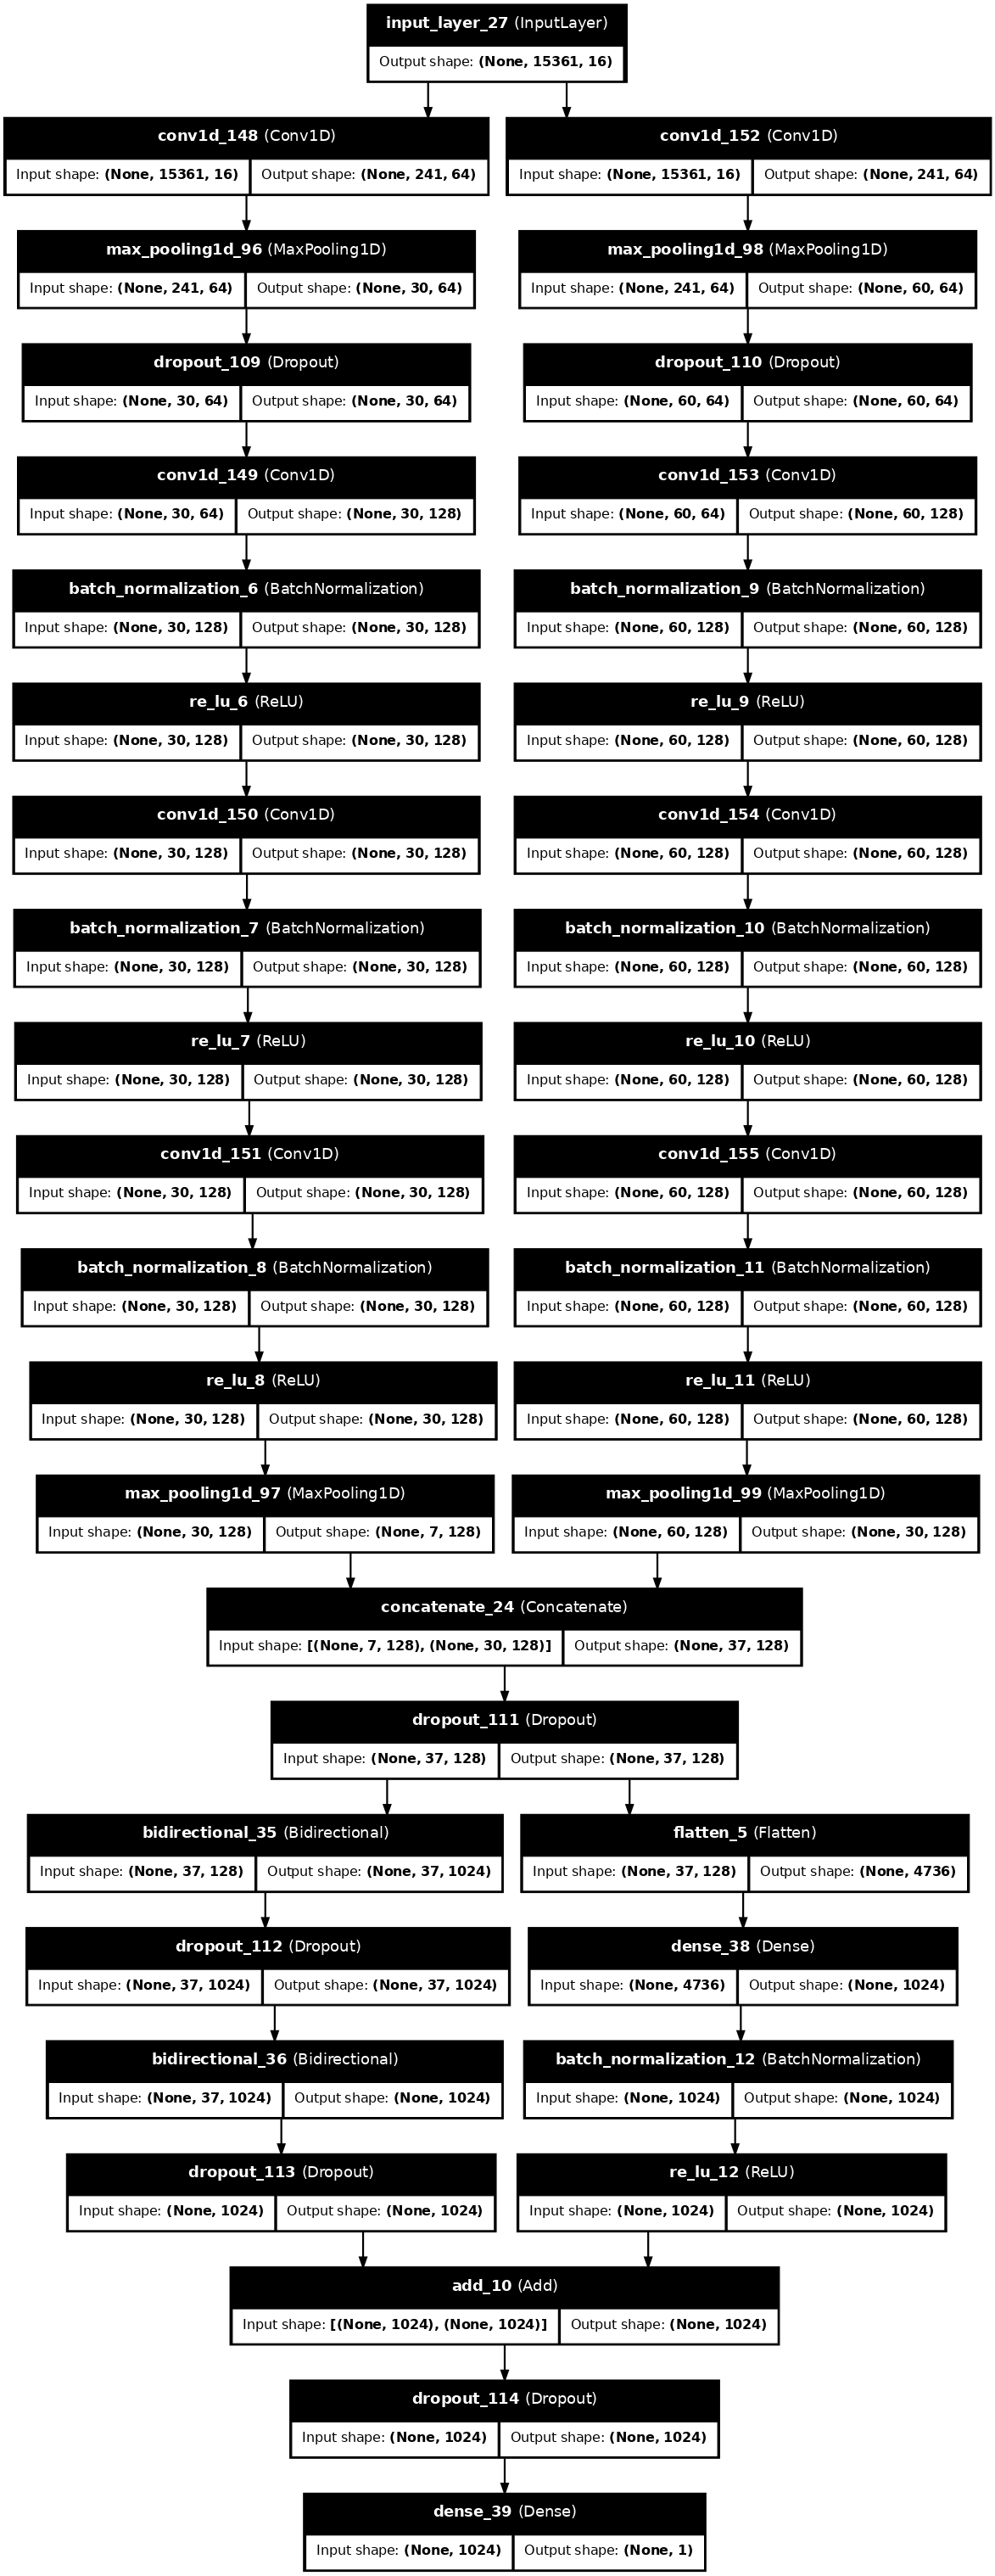

In [86]:
# mp = tf.keras.utils.model_to_dot(model, show_layer_names=True, show_shapes=True, dpi=80)
# with open("model_plot.dot", "w") as f:
#     f.write(mp.to_string())

tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, dpi=80)

In [89]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.BinaryFocalCrossentropy(),
    # loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      # tf.keras.metrics.Precision(name='precision'),
      # tf.keras.metrics.Recall(name='recall'),
      # tf.keras.metrics.AUC(name='auc'),
      # tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
])

In [90]:
# log_dir = "logs/fit/" + "scaled-cwt-mexh-cnn-3-no-ovr-60" #datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# model.fit(train_ds, epochs=100, validation_data=test_ds, callbacks=[tensorboard_callback])
history = model.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 208ms/step - accuracy: 0.5556 - fn: 23.7500 - fp: 19.5000 - loss: 0.6807 - tn: 10.4167 - tp: 47.0000 - val_accuracy: 0.6829 - val_fn: 0.0000e+00 - val_fp: 26.0000 - val_loss: 0.1695 - val_tn: 0.0000e+00 - val_tp: 56.0000
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.5540 - fn: 25.3333 - fp: 21.8333 - loss: 0.5998 - tn: 7.9167 - tp: 45.5833 - val_accuracy: 0.6829 - val_fn: 0.0000e+00 - val_fp: 26.0000 - val_loss: 0.1579 - val_tn: 0.0000e+00 - val_tp: 56.0000
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.5592 - fn: 24.6667 - fp: 19.3333 - loss: 0.4642 - tn: 12.4167 - tp: 44.2500 - val_accuracy: 0.6829 - val_fn: 0.0000e+00 - val_fp: 26.0000 - val_loss: 0.1670 - val_tn: 0.0000e+00 - val_tp: 56.0000
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.4959 - fn: 24.5833 - fp: 24.6667 - loss: 0.6816 - tn: 10.5833 - tp: 40.8333 - val_accuracy: 0.6829 - val_fn: 0.0000e+00 - val_fp: 26.0000 - val_los

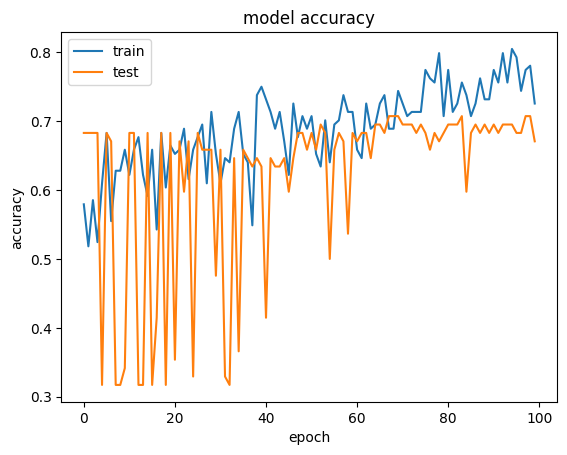

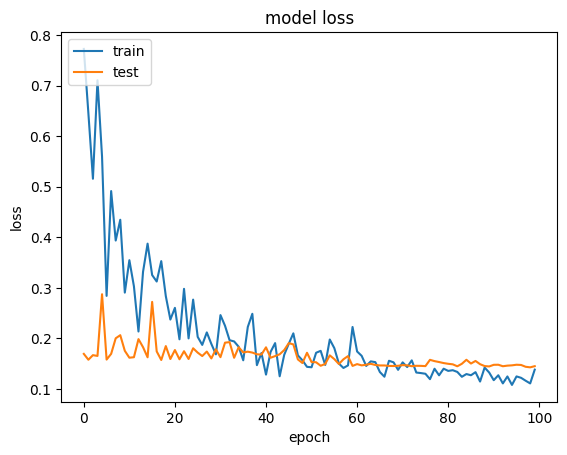

In [92]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Evaluate

In [93]:
model.evaluate(X_test, y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6518 - fn: 3.7500 - fp: 18.5000 - loss: 0.1465 - tn: 2.2500 - tp: 40.5000


[0.1451658457517624, 52.0, 23.0, 3.0, 4.0, 0.6707317233085632]

In [94]:
y_pred = model.predict(X_test) > 0.5

print("MCC:", np.round(matthews_corrcoef(y_test, y_pred), 4))
print("Accuracy:", np.round(accuracy_score(y_test, y_pred), 4))
print("Precision:", np.round(precision_score(y_test, y_pred), 4))
print("Recall:", np.round(recall_score(y_test, y_pred), 4))
print("F1:", np.round(f1_score(y_test, y_pred), 4))

print(classification_report(y_test, y_pred))

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f7e272e7be0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step
MCC: 0.0732
Accuracy: 0.6707
Precision: 0.6933
Recall: 0.9286
F1: 0.7939
              precision    recall  f1-score   support

           0       0.43      0.12      0.18        26
           1       

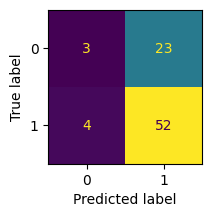

In [95]:
fig, ax = plt.subplots(figsize=(2, 2))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, colorbar=False)